# 50.039 Deep Learning Project

Group Members:
- Lee Chang Zheng
- Lee Cheng Xin
- Jason Peng Jing Ming

## Imports and CUDA

In [54]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchaudio import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
import librosa

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [56]:
# Set the seed
seed = 12
torch.manual_seed(seed)

## Audio Preprocessing Pipeline

We create a pipeline to streamline the processing of audio. 

In [57]:
import os, shutil, time
class ProcessingPipeline:
    def __init__(self, processes):
        self.processes = processes

    def run_pipeline(self,input_folder, output_folder):
        self.delete_files(output_folder)
        #if only 1 process, just output straight to output folder
        if len(self.processes) == 1:
            process = self.processes[0]
            print(process.__name__)
            process(input_folder, output_folder)
            return
        #Create two temporary folders for holding the files
        if not os.path.exists("tmp1"):
            os.makedirs("tmp1")
        if not os.path.exists("tmp2"):
            os.makedirs("tmp2")

        curr_folder = "./tmp1"
        next_folder = "./tmp2"
        #Process first function from input folder to temp folder
        process = self.processes[0]
        print(input_folder, curr_folder)
        print(process.__name__)
        process(input_folder, curr_folder)
        for i in range(1, len(self.processes) - 1):
            #Process Curr Folder to Next Folder
            process = self.processes[i]
            #Prepare next folder for processing
            self.delete_files(next_folder)
            #Process curr folder to next folder
            print(process.__name__)
            process(curr_folder, next_folder)
            #swap temporary folders, the next folder is now the curr folder and vice versa
            a = curr_folder
            curr_folder = next_folder
            next_folder = a
        process = self.processes[-1]
        #Finally, the final process goes to the output folder
        print(process.__name__)
        process(curr_folder, output_folder)
        #Clean up temporary folders
        self.delete_files("./tmp1")
        self.delete_files("./tmp2")
        os.rmdir("./tmp1")
        os.rmdir("./tmp2")

    def delete_files(self, folder):
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))


We perform the 4 operations in order:
1) Conversion of audio to .wav
2) Removal of noise
3) Trimming of silent regions
4) Padding for consistent dimensions

In [60]:
import subprocess
from pydub import AudioSegment
import os
from silence import trim_silence
from noise_reduction import noise_reduce

# Convert webm and ogg files to wav with single channel, sample rate of 48000 Hz, padded to 10 seconds long
def convert_audio(in_path, out_path):
    if '.webm' in in_path:
        subprocess.run(["ffmpeg", "-i", in_path, "-y", "-ac", "1", "-ar", "48000", out_path.replace('.webm', '.wav')])
    elif '.ogg' in in_path:
        subprocess.run(["ffmpeg", "-i", in_path, "-y", "-ac", "1", "-ar", "48000", out_path.replace('.ogg', '.wav')])
    elif '.wav' in in_path:
        subprocess.run(["ffmpeg", "-i", in_path, "-y", "-ac", "1", "-ar", "48000", out_path.replace('.wav', '.wav')])

# Pads and trims audio file to exactly 10 seconds long
def pad_trim_audio(in_path, out_path):
    audio = AudioSegment.from_wav(in_path)
    if len(audio) < 10000:
        padding = AudioSegment.silent(duration=10000 - len(audio))
        padded_audio = audio + padding
        padded_audio.export(out_path, format='wav')
    else:
        trimmed_audio = audio[:10000]
        trimmed_audio.export(out_path, format='wav')

# Calls pad_trim_audio for all files in the folder
def pad_folder(in_folder, out_folder):
    for filename in os.listdir(in_folder):
        pad_trim_audio(f'{in_folder}/{filename}', f'{out_folder}/{filename}')

# Calls convert_audio for all files in the folder
def convert_audio_folder(in_folder, out_folder):
    for filename in os.listdir(in_folder):
        convert_audio(f'{in_folder}/{filename}', f'{out_folder}/{filename}')


In [61]:
pipeline_functions = [convert_audio_folder, noise_reduce, trim_silence, pad_folder]
covid_pipeline = ProcessingPipeline(pipeline_functions)
#Uncomment if you want to run the processing pipeline, commented as data has been processed already in /Outputs
covid_pipeline.run_pipeline("./Inputs", "./Outputs")

convert_audio_folder
./tmp1 ./tmp2
noise_reduce
./tmp2 ./tmp1
trim_silence
pad_folder


## Converting Audio samples into Spectrograms

After standardizing the audio samples, we need to convert them into a Mel Spectrogram for the CNN model to process. 

In [62]:
# Converts the audio waveform into a mel spectrogram
def audio_to_spec(audio, sample_rate, n_mels=128, n_fft=400, win_length=None, hop_length=None, top_db=80):
    mel_spectrogram = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        n_mels=n_mels,
    )
    
    melspec = mel_spectrogram(audio)
    
    transform = transforms.AmplitudeToDB(top_db=top_db)
    final_spec = transform(melspec)
    return final_spec

## Custom Dataset and Dataloader

We create a custom dataset for the model. The custom dataset will convert the audio into a spectrogram before feeding it into the model. It will also ensure that the dimensions of the spectrograms are consistent, trimming and padding any spectrogram image that is too long or too short.

There is a method added to the Dataset that helps visualise the tensors.

In [64]:
class CovidCoughDataset(Dataset):
    def __init__(self, filename, datapath):
        df = pd.read_excel(filename)
        self.df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
        self.datapath = datapath
        self.max_spec_length = 2400

    def __getitem__(self, index):
        audio_file = self.datapath + self.df.iloc[index, 0] + '.wav'
        status = 1 if self.df.iloc[index, 1] == 'COVID' else 0        
        audio, sample_rate = torchaudio.load(audio_file)
        spec = audio_to_spec(audio=audio, sample_rate=sample_rate)
        
        # Note: There might be some minor differences in the length of the audio clips, resulting in spectrograms of different
        #       dimensions. We need to pad/trim the spectrograms to ensure consistency before we can feed into the model. 
        # Pad the shorter spectrograms to the maximum length
        if spec.shape[2] < self.max_spec_length:
            spec = F.pad(spec, (0, self.max_spec_length - spec.shape[2]), value=0)
        # Trim the longer spectrograms to the maximum length
        elif spec.shape[2] > self.max_spec_length:
            spec = spec[:, :, :self.max_spec_length]
        return spec, status
        
    def __len__(self):        
        return len(self.df)
    
    def visual_spectrogram(self,index):
        audio_file = self.datapath + self.df.iloc[index, 0] + '.wav'
        # status = 1 if self.df.iloc[index, 1] == 'COVID' else 0        
        audio, sample_rate = torchaudio.load(audio_file)
        spec = audio_to_spec(audio=audio, sample_rate=sample_rate)
        if spec.shape[2] < self.max_spec_length:
            spec = F.pad(spec, (0, self.max_spec_length - spec.shape[2]), value=0)
        # Trim the longer spectrograms to the maximum length
        elif spec.shape[2] > self.max_spec_length:
            spec = spec[:, :, :self.max_spec_length]

        fig, axs = plt.subplots(2, 1)
        plot_waveform(audio, sample_rate, title="Original waveform", ax=axs[0])
        plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
        fig.tight_layout()

# Plots a waveform for the audio clip
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)
    
# Plots a spectrogram of the audio clip
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

d:\anaconda3\envs\dlproject\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([1, 128, 2400])
None


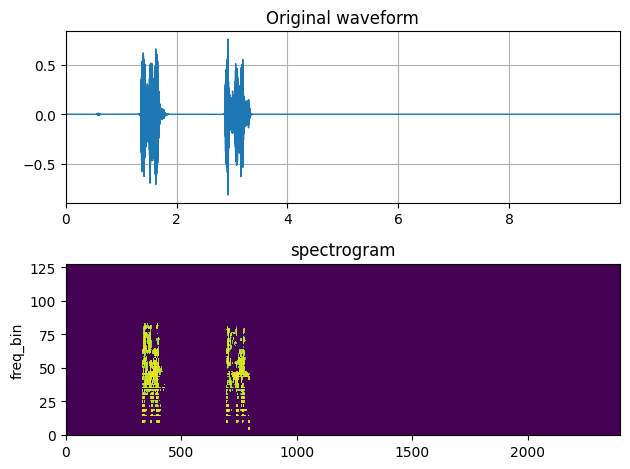

In [66]:
# Load the dataset
batch_size = 32
dataset = CovidCoughDataset('./Dataset.xlsx', './Outputs/')
print(dataset[0][0].shape)
print(dataset.visual_spectrogram(300))

# Setup teh train, valid and test dataloaders
train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [67]:
class CovidClassifer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=3)

        # Fully connected layers
        # Note: Each spectrogram is 128 x 2400. We divide by 9 as there are two 3 by 3 kernels with stride 1 and padding 1. 
        self.fc1 = nn.Linear(64 * (128//27) * (2400//27), 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        
        # Flattens the 2D images into 1D
        x = x.view(-1, 64 * (128//27) * (2400//27))
        x = self.fc1(x)
        
        return x

In [68]:
def evaluate(model, test_dataloader):
    # Set the model to evaluation mode
    model.eval()
    # Using cross entropy loss as our loss function
    criterion = nn.CrossEntropyLoss()
    
    # Initialize epoch loss and accuracy
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            # Send the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # Accumulate the total loss and correct predictions
            total_loss += loss.item()
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
    # Calculate epoch loss and accuracy
    total_loss /= len(test_dataloader)
    accuracy = correct/total
    
    return total_loss, accuracy

In [69]:
def train(model, train_dataloader, valid_dataloader, epochs = 10, lr = 0.001):
    # Using Adam as optimizer and cross entropy loss as our loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    # Used to store the performance curves of the train/valid loss/accuracy 
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for batch_number, (inputs, labels) in enumerate(train_dataloader):
            # Send the inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Compute the model output and loss
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            optimizer.step()
            # Accumulate the epoch loss and the total number of correct predictions
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_dataloader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
    
        # Evaluate the current model with validation set
        epoch_loss, epoch_acc = evaluate(model, valid_dataloader)    
        valid_losses.append(epoch_loss)
        valid_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Validation loss: {epoch_loss:.4f}, Validation accuracy: {epoch_acc:.4f}')
        torch.save(model.state_dict(),f"model_iter{epoch}.pt")            
    
    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [70]:
model = CovidClassifer().to(device)
# Train the model!
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, train_dataloader, valid_dataloader, epochs = 2, lr = 0.001)

Epoch 1/2, Batch number: 0, Cumulated accuracy: 0.5
Epoch 1/2, Batch number: 1, Cumulated accuracy: 0.59375
Epoch 1/2, Batch number: 2, Cumulated accuracy: 0.5520833333333334
Epoch 1/2, Batch number: 3, Cumulated accuracy: 0.53125
Epoch 1/2, Batch number: 4, Cumulated accuracy: 0.53125
Epoch 1/2, Batch number: 5, Cumulated accuracy: 0.53125
Epoch 1/2, Batch number: 6, Cumulated accuracy: 0.4955357142857143
Epoch 1/2, Batch number: 7, Cumulated accuracy: 0.4921875
Epoch 1/2, Batch number: 8, Cumulated accuracy: 0.4791666666666667
Epoch 1/2, Batch number: 9, Cumulated accuracy: 0.484375
Epoch 1/2, Batch number: 10, Cumulated accuracy: 0.4914772727272727
Epoch 1/2, Batch number: 11, Cumulated accuracy: 0.4895833333333333


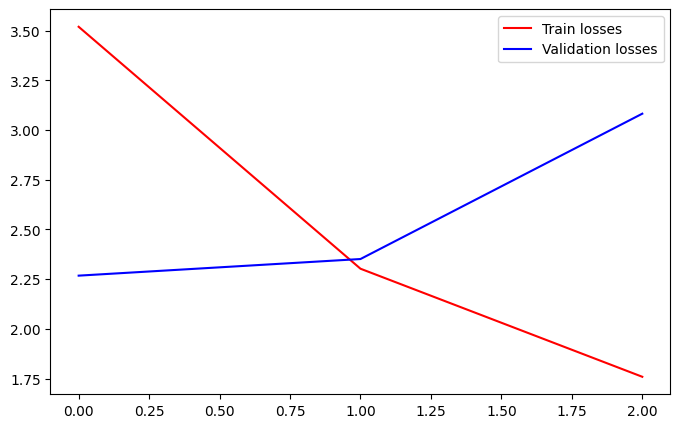

In [ ]:
# Plot the train and validation loss curves
plt.figure(figsize = (8, 5))
plt.plot(train_losses, "r-", label = "Train losses")
plt.plot(valid_losses, "b-", label = "Validation losses")
plt.legend(loc = "best")
plt.show()

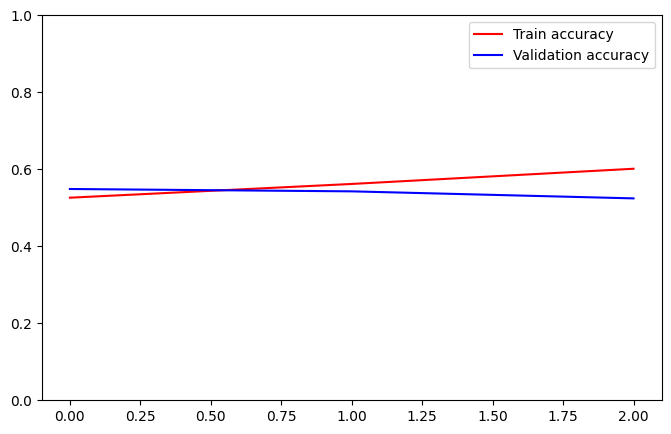

In [ ]:
# Plot the train and validation accuracy curves
plt.figure(figsize = (8, 5))
plt.plot(train_accuracies, "r-", label = "Train accuracy")
plt.plot(valid_accuracies, "b-", label = "Validation accuracy")
plt.legend(loc = "best")
plt.ylim([0, 1])
plt.show()

In [ ]:
# Load the best model
model.load_state_dict(torch.load("model_iter0"))
model.eval()
# Evaluate the model on the test set
loss, accuracy = evaluate(model, test_dataloader)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

CovidClassifer(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=22528, out_features=2, bias=True)
)